<a href="https://colab.research.google.com/github/pcarbo/rnaseq_tutorial/blob/main/hypoxia_deseq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A brief introduction to differential expression analysis with DESeq2
====================================================================
Peter Carbonetto<br>
University of Chicago<br>
Chicago, IL<br>
*Last modified on September 26, 2023*

This is only a brief tutorial on [DESeq2](https://github.com/thelovelab/DESeq2). For a much more in-depth introduction to DESeq2, I strongly recommend the [vignette](https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) included in the DESeq2 R package.

*Disclaimer:* This tutorial may contain bugs or mistakes in the text. Please report any mistakes or bug fixes by posting a [GitHub Issue](https://github.com/pcarbo/rnaseq_tutorial/issues) or, better yet, by submitting a [pull request](https://github.com/pcarbo/rnaseq_tutorial/pulls).

Initial setup
-------------

Run this line of code to check that you have a heartbeat (*i.e.*, a working virtual machine):

In [1]:
sample(1000000,1)

[1] 80089

This step is optional, but I run this every time in Jupyter notebook or Google Colab to make the code outputs look like they do in RStudio:

In [2]:
options(jupyter.rich_display = FALSE)

Install the packages from CRAN and Bioconductor that we will use to run the differential expression analysis. Note this may take a few minutes to complete as DESeq2 depends on many other packages that will also need to be installed.

In [123]:
install.packages("ashr")
install.packages("BiocManager")
BiocManager::install("DESeq2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘irlba’, ‘truncnorm’, ‘mixsqp’, ‘SQUAREM’, ‘etrunct’, ‘invgamma’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'”
Old packages: 'bit', 'devtools', 'gargle', 'gert', 'highr', 'isoband', 'knitr',
  'openssl', 'pkgload', 'prettyunits', 'rmarkdown', 'roxygen2', 'whisker',
  'withr', 'boot', 'foreign', 'Matrix', 'nlme'



In [48]:
library(DESeq2)
library(ashr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

Now download and import the RNA-seq data into R. The data are from a [recent paper](https://doi.org/10.1126/sciadv.ade1942) studying transcriptional responses to sustained hypoxia.

In [36]:
download.file("https://raw.githubusercontent.com/pcarbo/rnaseq_tutorial/main/hypoxia.RData","hypoxia.RData")

In [38]:
load("hypoxia.RData")

A quick look at the data
------------------------

If you were successful, you should have two new objects in your environment containing the RNA-seq data.

In [39]:
ls()

[1] "counts"  "samples"

The data consist of RNA-seq read counts measured in two conditioins (normoxia and hypoxia) for 3 ENH5-knockout and 3 wild-type clones.

In [40]:
samples

   Sample_ID Line Rep Treatment
1  KO3.H     KO   KO3 Hypoxia  
2  KO3.N     KO   KO3 Normoxia 
3  KO4.H     KO   KO4 Hypoxia  
4  KO4.N     KO   KO4 Normoxia 
5  KO5.H     KO   KO5 Hypoxia  
6  KO5.N     KO   KO5 Normoxia 
7  WT4.H     WT   WT4 Hypoxia  
8  WT4.N     WT   WT4 Normoxia 
9  WT5.H     WT   WT5 Hypoxia  
10 WT5.N     WT   WT5 Normoxia 
11 WT6.H     WT   WT6 Hypoxia  
12 WT6.N     WT   WT6 Normoxia 

The RNA-seq data are counts stored in a matrix with rows corresponding to genes and columns corresponding to samples.

In [47]:
class(counts)
nrow(counts)
ncol(counts)
head(counts,n = 10)

[1] "matrix" "array" 

[1] 30123

[1] 12

        KO3.H KO3.N KO4.H KO4.N KO5.H KO5.N WT4.H WT4.N WT5.H WT5.N WT6.H WT6.N
5S_rRNA    0    0      0    0      0     0     0    0      0     0    0     0  
A1BG     118   71    119   41     99    85   152   82    211   109  161    58  
A1CF       0    0      0    0      0     0     0    0      0     0    0     0  
A2M      394  140    439  195    179   387   403  155    148    31    7    13  
A2ML1      0    0      0    0      0     0     1    0      0     0    0     0  
A2MP1      0    0      0    0      0     0     0    0      0     0    0     0  
A3GALT2    0    0      0    0      0     0     0    0      0     0    0     0  
A4GALT  1703  971   2486  919   3176  1573  1495  777   1906  1287  854   837  
A4GNT      0    0      0    0      0     0     0    0      0     0    0     0  
AAAS     842  941    892  551    894   940   930  941    896   962  941   881  

For the moment, let's focus on the data from the wild-type mice:

In [52]:
i <- which(samples$Line == "WT")
counts <- counts[,i]
samples <- samples[i,]
dim(counts)
samples

[1] 30123     6

   Sample_ID Line Rep Treatment
7  WT4.H     WT   WT4 Hypoxia  
8  WT4.N     WT   WT4 Normoxia 
9  WT5.H     WT   WT5 Hypoxia  
10 WT5.N     WT   WT5 Normoxia 
11 WT6.H     WT   WT6 Hypoxia  
12 WT6.N     WT   WT6 Normoxia 

What is a DE analysis?
----------------------

Fundamentally, in order to study the effect of hypoxia on expression, we would like to compare the read counts in the "hypoxia" condition to the read counts in the "normoxia" condition. It is helpful to take a few examples to see what these comparisons look like. Take the gene *EGNL3:

In [85]:
pdat <- data.frame(Treatment = samples$Treatment,
                   EGLN3 = counts["EGLN3",])
pdat

      Treatment EGLN3
WT4.H Hypoxia   5739 
WT4.N Normoxia     2 
WT5.H Hypoxia   5638 
WT5.N Normoxia     0 
WT6.H Hypoxia   6509 
WT6.N Normoxia     7 

In [141]:
options(repr.plot.width = 4,repr.plot.height = 4.5,repr.plot.res = 175)
boxplot(EGLN3 ~ Treatment,data = pdat,boxwex = 0.25)

ERROR: ignored

In [81]:
e1 <- mean(subset(pdat,Treatment == "Hypoxia")$EGLN3)
e0 <- mean(subset(pdat,Treatment == "Normoxia")$EGLN3)
e1
e0
log2(e1/e0)

[1] 5962

[1] 3

[1] 10.95662

This gene was actually highlighted in the paper because of its very large response to hypoxia, and indeed from a back-of-the-envelope calculation we got a very large LFC. However, most genes chosen at random will see changes to expression, both up and down, but the changes are more ambiguous. Let's take another example:

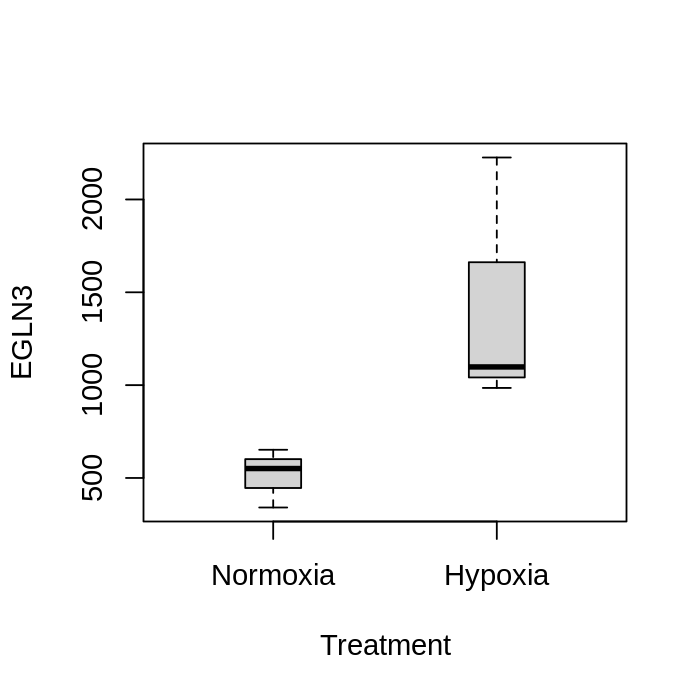

In [83]:
pdat <- data.frame(Treatment = samples$Treatment,
                   EGLN3 = counts["TNFRSF12A",])
boxplot(EGLN3 ~ Treatment,data = pdat,boxwex = 0.25)

In [84]:
e1 <- mean(subset(pdat,Treatment == "Hypoxia")$EGLN3)
e0 <- mean(subset(pdat,Treatment == "Normoxia")$EGLN3)
e1
e0
log2(e1/e0)

[1] 1436.333

[1] 514.6667

[1] 1.48068

A central question is *which genes* have changes that are *significantly different* between the two conditions. We will use DESeq2 to answer this question more systematically. Again, we will focus on changes in hypoxia vs. normoxia in the WT mice.

A DE analysis using DESeq2
--------------------------

The first step in analyzing data using DESeq2 is to convert the data to an encoding that is convenient for DESeq2:

In [87]:
dat <- DESeqDataSetFromMatrix(counts,samples,~Treatment)

In [90]:
print(dat)

class: DESeqDataSet 
dim: 30123 6 
metadata(1): version
assays(1): counts
rownames(30123): 5S_rRNA A1BG ... ZZEF1 ZZZ3
rowData names(0):
colnames(6): WT4.H WT4.N ... WT6.H WT6.N
colData names(4): Sample_ID Line Rep Treatment


Once we have set up our data for DESeq2, analyzing the data using DESeq2 is quite straightforward:

In [92]:
deseq <- DESeq(dat)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Having run this analysis, we now have more rigorous LFC estimates:

    AGTR1       CA2     EGLN3     ENKUR     MCHR1     SRARP 
 8.018614  8.836889 11.022365  9.376843  8.418889 12.315100 

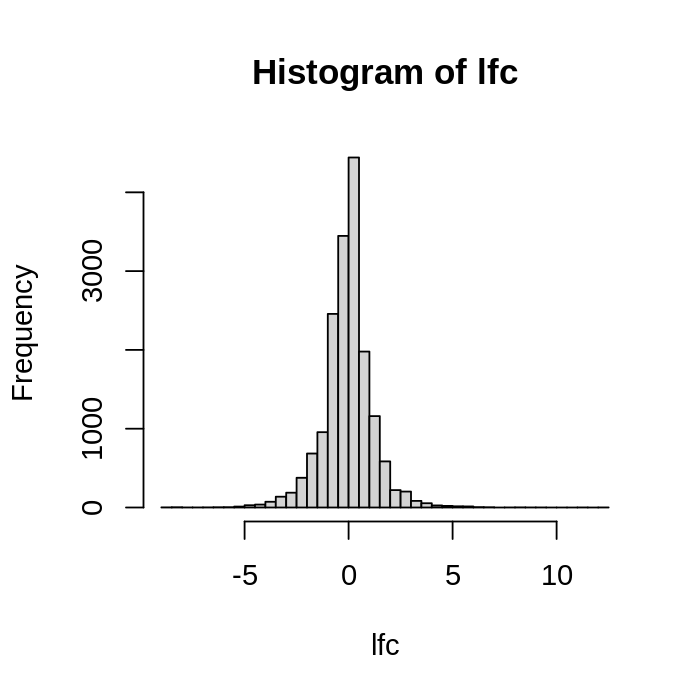

In [133]:
lfc <- coef(deseq)[,"Treatment_Hypoxia_vs_Normoxia"]
hist(lfc,n = 64)
lfc[which(lfc > 8)]

We can extract other statistics such as standard errors and p-values using the `results()` function:

In [106]:
res <- results(deseq,alpha = 0.05,contrast = list("Treatment_Hypoxia_vs_Normoxia"))

In [111]:
head(res)

log2 fold change (MLE): Treatment_Hypoxia_vs_Normoxia effect 
Wald test p-value: Treatment_Hypoxia_vs_Normoxia effect 
DataFrame with 6 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue       padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric>  <numeric>
5S_rRNA   0.000000             NA        NA        NA         NA         NA
A1BG    129.939775        1.14230  0.336866  3.390961 0.00069648 0.00316765
A1CF      0.000000             NA        NA        NA         NA         NA
A2M     127.292510        1.53126  1.494817  1.024376 0.30565766 0.45037760
A2ML1     0.167264        1.02760  4.080473  0.251834 0.80116929         NA
A2MP1     0.000000             NA        NA        NA         NA         NA

In [112]:
res["EGLN3",]

log2 fold change (MLE): Treatment_Hypoxia_vs_Normoxia effect 
Wald test p-value: Treatment_Hypoxia_vs_Normoxia effect 
DataFrame with 1 row and 6 columns
       baseMean log2FoldChange     lfcSE      stat       pvalue         padj
      <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
EGLN3   3041.03        11.0224  0.507557   21.7165 1.43279e-104 9.31531e-101

In [113]:
res["TNFRSF12A",]

log2 fold change (MLE): Treatment_Hypoxia_vs_Normoxia effect 
Wald test p-value: Treatment_Hypoxia_vs_Normoxia effect 
DataFrame with 1 row and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
TNFRSF12A   979.263        1.54434  0.369421   4.18045 2.90937e-05 0.000202845

With these statistics we can easily generate a "volcano plot" showing the LFC estimate on the X axis and some measure of support or significance on the Y axis (e.g., a p-value).

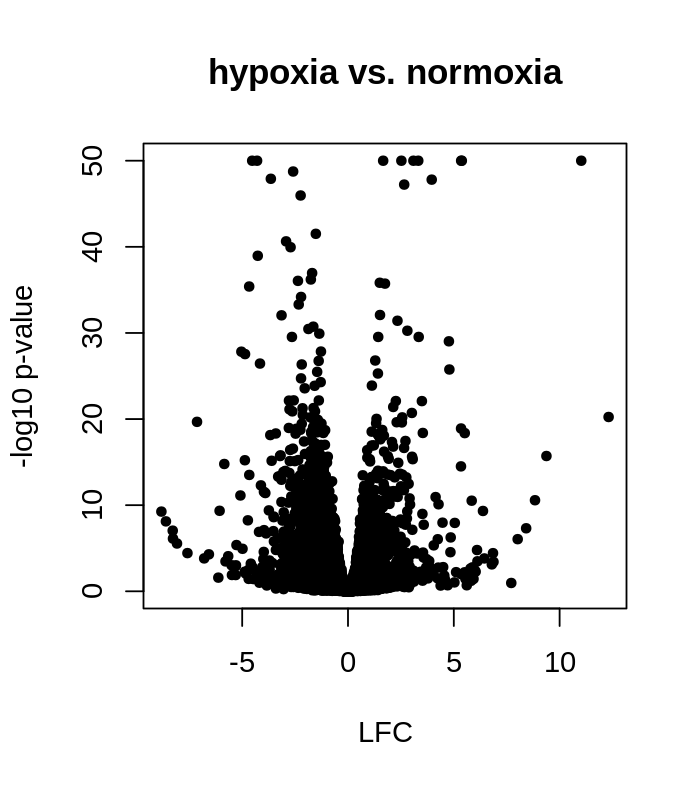

In [143]:
pdat <- data.frame(lfc = res$log2FoldChange,
                   pval = -log10(res$padj))
pdat <- transform(pdat,pval = pmin(50,pval))
plot(pdat$lfc,pdat$pval,pch = 20,
     xlab = "LFC",ylab = "-log10 p-value",
     main = "hypoxia vs. normoxia")

In [125]:
subset(res,log2FoldChange > 6 & padj < 1e-5)

log2 fold change (MLE): Treatment_Hypoxia_vs_Normoxia effect 
Wald test p-value: Treatment_Hypoxia_vs_Normoxia effect 
DataFrame with 7 rows and 6 columns
       baseMean log2FoldChange     lfcSE      stat       pvalue         padj
      <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
AGTR1   45.4414        8.01861  1.482807   5.40773  6.38301e-08  8.87681e-07
CA2     80.0279        8.83689  1.228865   7.19110  6.42713e-13  2.67003e-11
DEPP1 2023.9632        6.37815  0.945058   6.74895  1.48917e-11  4.71136e-10
EGLN3 3041.0290       11.02237  0.507557  21.71650 1.43279e-104 9.31531e-101
ENKUR  216.1671        9.37684  1.070343   8.76059  1.94225e-18  1.95776e-16
MCHR1   30.6785        8.41889  1.411848   5.96303  2.47606e-09  4.83427e-08
SRARP  456.8151       12.31510  1.239531   9.93529  2.92314e-23  5.75903e-21

A brief behind-the-scenes look
------------------------------

DESeq2 has two features that are important to most DE analyses:

One, it can account for different *sequencing depths* among the RNA-seq samples:

In [158]:
sizeFactors(deseq)

    WT4.H     WT4.N     WT5.H     WT5.N     WT6.H     WT6.N 
0.9964303 1.0085583 0.9490630 1.0271749 0.9956682 1.0422541 

Two, it accounts for *overdispersion*—that is, additional variation that cannot be captured by the Poisson distribution:

In [159]:
summary(dispersions(deseq))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.005   0.022   0.057   1.861   1.204  10.000   12893 

Improving the LFC estimates using shrinkage
-------------------------------------------

A nice feature of DESeq2 is that it provides an additional function `lfcShrink` for "shrinking" the LFC estimates—essentially, borrowing information across all genes to reduce the "noise" in the estimates. Let's see how doing this improves our analysis.

In [150]:
res_shrunk <- lfcShrink(deseq,coef = "Treatment_Hypoxia_vs_Normoxia",type = "ashr",svalue = TRUE)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



In [151]:
head(res_shrunk)

log2 fold change (MMSE): Treatment Hypoxia vs Normoxia 
 
DataFrame with 6 rows and 4 columns
          baseMean log2FoldChange     lfcSE      svalue
         <numeric>      <numeric> <numeric>   <numeric>
5S_rRNA   0.000000      0.0000000  0.752859 0.224547824
A1BG    129.939775      0.8674312  0.335041 0.000324584
A1CF      0.000000      0.0000000  0.752859 0.224563809
A2M     127.292510      0.2199456  0.598852 0.096761627
A2ML1     0.167264      0.0282517  0.678154 0.190988557
A2MP1     0.000000      0.0000000  0.752859 0.224579792

Let's now compare the LFC estimates before and after shrinkage:

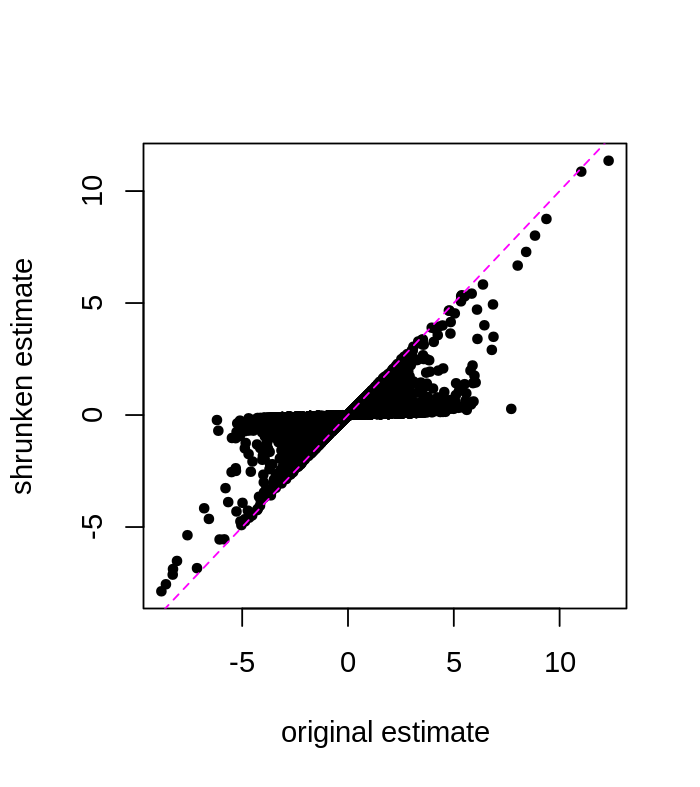

In [148]:
pdat <- data.frame(est = coef(deseq)[,"Treatment_Hypoxia_vs_Normoxia"],
                   shrunk = res_shrunk$log2FoldChange)
plot(pdat$est,pdat$shrunk,pch = 20,
     xlab = "original estimate",
     ylab = "shrunken estimate")
abline(a = 0,b = 1,lty = "dashed",col = "magenta")

Here is what the volcano plot looks like with the shrunken estimates. (It is recommended to use the s-values provided by `ashr` instead of the p-values.)

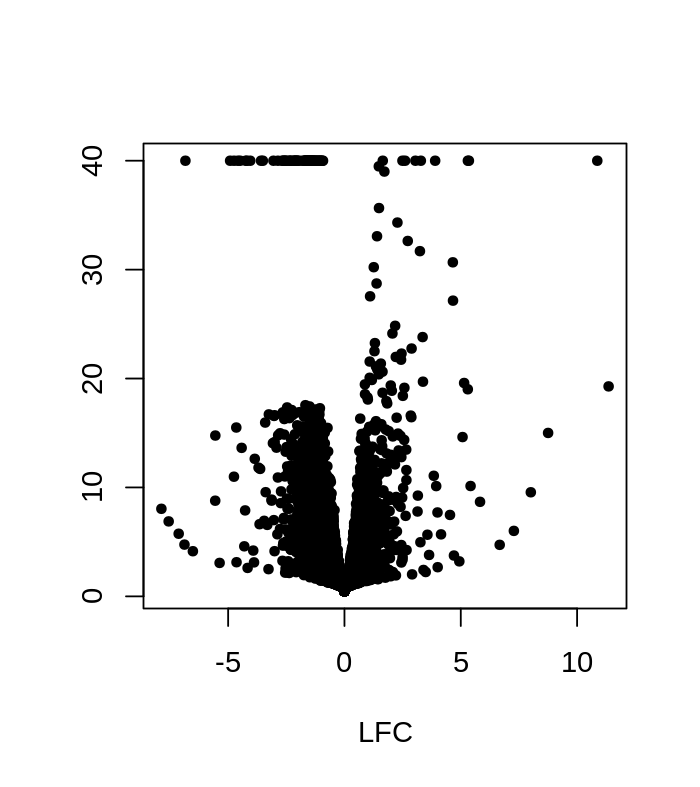

In [154]:
pdat <- data.frame(lfc = res_shrunk$log2FoldChange,
                   sval = -log10(res_shrunk$svalue))
pdat <- transform(pdat,sval = pmin(40,sval))
plot(pdat$lfc,pdat$sval,pch = 20,
     xlab = "shrunken LFC",ylab = "-log10 s-value")

"Blunting" of hypoxia response due to deletion of the *ENH5* enhancer
---------------------------------------------------------------------

To practice our newly acquired skills, let's redo the steps of the DESeq2 analysis using the RNA-seq data from the knockout (KO) mice.

In [180]:
load("hypoxia.RData")
i <- which(samples$Line == "KO")
counts <- counts[,i]
samples <- samples[i,]
dat_ko <- DESeqDataSetFromMatrix(counts,samples,~Treatment)
deseq_ko <- DESeq(dat_ko)
res_ko <- results(deseq_ko,alpha = 0.05,contrast = list("Treatment_Hypoxia_vs_Normoxia"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Reassuringly, many of the top upregulated genes in the knockout mice are the same as what we saw before in the wild-type mice:

In [186]:
subset(res_ko,log2FoldChange > 8)

log2 fold change (MLE): Treatment_Hypoxia_vs_Normoxia effect 
Wald test p-value: Treatment_Hypoxia_vs_Normoxia effect 
DataFrame with 5 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
C5orf46   62.9274        9.40442  2.800750   3.35782 7.85588e-04 6.18974e-03
EGLN3   1889.5302        9.88444  0.474994  20.80961 3.54243e-96 2.33198e-92
SLC9C2    38.2968        8.68877  1.401803   6.19828 5.70848e-10 3.05520e-08
SMIM43   189.4371        8.03816  1.777120   4.52314 6.09289e-06 1.07261e-04
SRARP    166.7783        8.95378  1.204341   7.43459 1.04896e-13 1.19057e-11

To reproduce one of the main results of the paper, compare the LFC estimates from our DESeq2 analysis of the wild-type and knockout samples:

In [181]:
pdat <- data.frame(wt = res$log2FoldChange,
                   ko = res_ko$log2FoldChange)
fit <- lm(ko ~ wt,pdat)
coef(fit)

(Intercept)          wt 
-0.03315899  0.50727613 

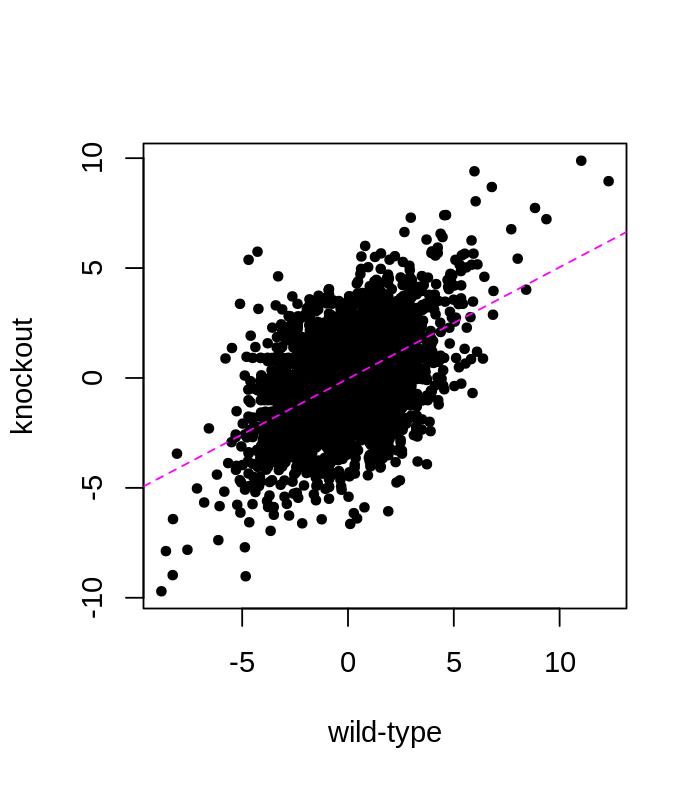

In [187]:
plot(pdat$wt,pdat$ko,pch = 20,xlab = "wild-type",ylab = "knockout")
abline(a = coef(fit)[1],b = coef(fit)[2],col = "magenta",lty = "dashed")

Compare this plot to Fig. 3 of the paper.